# MIE1624 Introduction to Data Science and Analytics

## Assignment#1 KaggleSalary DayaSet Analysis

## Yixiao Hong - 1001311145

## 0.Background:
Kaggle has hosted an open data scientist competition in 2019 titled “2019 Kaggle ML & DS Survey
Challenge.” The purpose of this challenge was to “tell a data story about a subset of the data science
community represented in this survey, through a combination of both narrative text and data
exploration.” More information on the competition, data, and prizes can be found on:
https://www.kaggle.com/c/kaggle-survey-2019
The original dataset (multiple_choice_responses.csv) contains the survey results provided by Kaggle.
The survey results from 19717 participants are shown in 246 columns, representing survey questions. Not
all questions are answered by each participant, and responses contain various data types. 

### 0.1 The purpose of this assignment:


1.   understand and explore employment in the data science community, as represented in a survey conducted by Kaggle.
2.   train, validate, and tune multi-class ordinary classification problem that can classify, given a set of survey responses by a data scientist, what a survey respondent’s current yearly compensation bucket is.


### 0.2 Import libraries needed for the project:

In [0]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

## 1.Data cleaning (20 marks):
While the data is made ready for analysis, several values are missing, and some features are categorical. Note that some values that appear “null” indicate that a survey respondent did not select that given option from a multiple-choice list. For example – “Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Twitter (data science influencers)” For the data cleaning step, handle missing values however you see fit and justify your approach. Provide some insight on why you think the values are missing and how your approach might impact the overall analysis. Suggestions include filling the missing values with a certain value (e.g. mode for categorical data) and completely removing the features with missing values. Secondly, convert 3/6 MIE 1624 Introduction to Data Science and Analytics – Assignment 1 categorical data into numerical data by encoding and explain why you used this particular encoding method. These tasks can be done interchangeably, e.g., encoding can be done first.

### 1.1 Load the dataset

In [2]:
#Read the KaggleSalary DataSet
df = pd.read_csv("https://raw.githubusercontent.com/YixiaoHong/Kaggle_Salary_Data_Analysis/master/src/Kaggle_Salary.csv", low_memory = False)

#Read the KaggleSalary Questions and build it to a dictionary based on column name so that we can always find what question this column is asking for in the future:
df_q = pd.read_csv("https://raw.githubusercontent.com/YixiaoHong/Kaggle_Salary_Data_Analysis/master/src/multiple_choice_responses.csv", low_memory = False)
df_q = df_q.iloc[0]
df_q_dict = df_q.to_dict()

#have a brief view of the raw data
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"250,000-299,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,-1,NaN,Coursera,edX,DataCamp,NaN,...,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"4,000-4,999",$0 (USD),NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,Other,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",NaN,NaN,Build prototypes to explore applying machine l...,NaN,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"60,000-69,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,RapidMiner,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,Auto-Keras,NaN,NaN,NaN,Na

In [3]:
df.shape

(12497, 248)

### 1.2 Remove Unrelated Columns
1.   After briefly looking at the dataset, I noticed that there are some columns with label of "OTHER_TEXT", which is encooded with numbers and provides no useful information to the analysis, thus I drop the columns with "OTHER_TEXT" 
2.   The first dolumn is "Time from Start to Finish (seconds)" which stores the data stored time, which potentially contributes little to the analysis, thus this column can also be dropped



In [4]:
#Remove column including "OTHER_TEXT" and  "Time from Start to Finish (seconds)" 
dropList = []
for col in df.columns:
  if "TEXT" in col or "Time from Start to Finish (seconds)" in col:
    dropList.append(col)
# print(dropList)
print("Find",len(dropList),"columns which needs to be dropped")
df = df.drop(columns = dropList)
display(df)

Find 29 columns which needs to be dropped


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,...,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q10_Encoded,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,"5,000-7,499","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"0-9,999"
2,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"250,000-299,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,NaN,Coursera,edX,DataCamp,NaN,NaN,NaN,NaN,NaN,University Courses (resulting in a university ...,...,NaN,NaN,NaN,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,14,">250,000"
3,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,000-4,999",$0 (USD),NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"0-9,999"
4,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",NaN,NaN,Build prototypes to explore applying machine l...,NaN,NaN,Do research that advances the state of the art...,NaN,NaN,"60,000-69,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...

### 1.3 Implement Strategy to Fill missing values (Nan)

#### 1.3.1 Check unique values of each colum

In [5]:
for col in df.columns:
  print("=================")
  print(col)
  print("==> Unique Values:")
  print(df[col].unique())
  print("==> Number of unique Values:")
  print(len(df[col].unique()))

Q1
==> Unique Values:
['22-24' '40-44' '50-54' '55-59' '30-34' '18-21' '35-39' '25-29' '45-49'
 '60-69' '70+']
==> Number of unique Values:
11
Q2
==> Unique Values:
['Male' 'Female' 'Prefer to self-describe' 'Prefer not to say']
==> Number of unique Values:
4
Q3
==> Unique Values:
['France' 'India' 'Australia' 'United States of America' 'Netherlands'
 'Germany' 'Ireland' 'Russia' 'Greece' 'Ukraine' 'Pakistan' 'Japan'
 'Other' 'Brazil' 'South Korea' 'Belarus' 'Nigeria'
 'United Kingdom of Great Britain and Northern Ireland' 'Sweden' 'Mexico'
 'Canada' 'Portugal' 'Poland' 'Indonesia' 'Italy' 'Czech Republic' 'Spain'
 'Chile' 'Hong Kong (S.A.R.)' 'South Africa' 'Argentina' 'Turkey' 'Israel'
 'Taiwan' 'Egypt' 'Morocco' 'Hungary' 'Colombia' 'Norway' 'Thailand'
 'Switzerland' 'Viet Nam' 'Singapore' 'Bangladesh'
 'Iran, Islamic Republic of...' 'Peru' 'Kenya' 'Romania' 'China' 'Belgium'
 'Austria' 'Algeria' 'New Zealand' 'Tunisia' 'Philippines' 'Malaysia'
 'Republic of Korea' 'Denmark' 'Saudi 

#### 1.3.2 Check which columns have NaN 

In [6]:
def CheckAnyNulls(check_df):
  nanSum = check_df.isna().sum()
  # print(len(nanSum))
  nanCols = []
  for col in nanSum.index:
    # print(nanSum[col])
    if nanSum[col] !=0:
      # print("Column:",col,"has",nanSum[col],"nan entries")
      nanCols.append(col)
  # print(len(nanCols),"out of",len(df.columns),"has NaN valus")
  return len(nanCols)

print(CheckAnyNulls(df),"out of",len(df.columns),"has NaN valus")

208 out of 219 has NaN valus


#### 1.3.3 Interpret NaN valus and Fill the NaN entries(Binary value columns)


> Notice that some of the columns which has Nan values has only binary unique values, in this case the NaN value can be interprete as "Not Selected"



> fill the columns which has binary values and include NaN as Nan = "Not Selected"





In [7]:
#fill the columns which has binary values and include NaN as Nan = 0 (means not selected) and the non-NaN value = 1 (means selected)
binaryCols_with_nan = []
nanSum = df.isna().sum()
for col in df.columns:
  if len(df[col].unique()) == 2 and nanSum[col] !=0: #which is a binary value column and one value is nan
    binaryCols_with_nan.append(col)

print("Number of Binary value columns with Nan:",len(binaryCols_with_nan))

print("==>Cleaning the binary value columns, nan= \"Not Selected")
for col in binaryCols_with_nan:
  df[col]=np.where(df[col].isna(),"Not Selected",df[col])

display(df)

Number of Binary value columns with Nan: 202
==>Cleaning the binary value columns, nan= "Not Selected


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,...,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q10_Encoded,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,"30,000-39,999",$0 (USD),Twitter (data science influencers),Not Selected,Not Selected,"Kaggle (forums, blog, social media, etc)",Not Selected,Not Selected,Not Selected,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,Not Selected,Not Selected,Not Selected,Not Selected,Coursera,Not Selected,DataCamp,Not Selected,Kaggle Courses (i.e. Kaggle Learn),Not Selected,Udemy,Not Selected,Not Selected,...,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Not Selected,Not Selected,Not Selected,Not Selected,"5,000-7,499","> $100,000 ($USD)",Not Selected,Not Selected,Not Selected,"Kaggle (forums, blog, social media, etc)",Not Selected,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Coursera,Not Selected,DataCamp,Not Selected,Kaggle Courses (i.e. Kaggle Learn),Not Selected,Udemy,Not Selected,Not Selected,...,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,0,"0-9,999"
2,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,"250,000-299,999","$10,000-$99,999",Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",Not Selected,Not Selected,Not Selected,Coursera,edX,DataCamp,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,University Courses (resultin

#### 1.3.4 Analyze NaN values in non-binary value columns


> Notice that some of the columns which has Nan values has non-binary unique values, in this case the NaN value has to be solved from case to case. I firstly print out the percentage of NaN in each column


In [8]:
#Check the other columns with nan which is not binary
non_binaryCols_with_nan = []
nanSum_after_clean_binary = df.isna().sum()
for col in df.columns:
  if len(df[col].unique()) !=2 and nanSum_after_clean_binary[col] !=0: #which is a binary value column and one value is nan
    non_binaryCols_with_nan.append(col)

print("Number of non-Binary value columns with Nan:",len(non_binaryCols_with_nan),"they are:")
print("==========================================================================")
 
for col in non_binaryCols_with_nan:
  print(col,":",df_q_dict[col])
  print("\nUnique Values==>:",df[col].unique())
  print("\nThere are ",nanSum_after_clean_binary[col],"entries has nan which occupies",round(nanSum_after_clean_binary[col]/len(df)*100,2),"% of all data for this column")
  print("==========================================================================")



Number of non-Binary value columns with Nan: 6 they are:
Q11 : Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?

Unique Values==>: ['$0 (USD)' '> $100,000 ($USD)' '$10,000-$99,999' '$100-$999'
 '$1000-$9,999' '$1-$99' nan]

There are  247 entries has nan which occupies 1.98 % of all data for this column
Q14 : What is the primary tool that you use at work or school to analyze data? (Include text response) - Selected Choice

Unique Values==>: ['Basic statistical software (Microsoft Excel, Google Sheets, etc.)'
 'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)'
 'Local development environments (RStudio, JupyterLab, etc.)'
 'Advanced statistical software (SPSS, SAS, etc.)' 'Other'
 'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)'
 nan]

There are  1045 entries has nan which occupies 8.36 % of all data for this column
Q15 : How long have you been writing code to analyze data (at w

> After summarizing the NaNs for the non-binary value columns we find there are 6 non-binary value columns with NaNs and the rate of nan is ranging from 1.98% to 15.65%.

#### 1.3.5 Fill the NaN entries(non-binary value columns)
The strategy of filling the non-binary NaN entries is to drop the rows with NaN if the column has less than 5% NaN, if it has more than 5% NaN, I will fill the NaN with mode value, the Pros of doing this is that it is simple. The con of doing that is it has a risk of ends up dropping too many rows and some features are losing

In [9]:
print("Before cleaning,", CheckAnyNulls(df),"out of",len(df.columns),"has NaN valus")
print("Before cleaning,There are",df.shape[0],"rows")
for col in non_binaryCols_with_nan:
  if round(nanSum_after_clean_binary[col]/len(df),2) <=0.05:
    df.dropna(subset=[col],inplace=True)
  else:
    df[col].fillna(df[col].mode()[0], inplace=True)
print("After cleaning,",CheckAnyNulls(df),"out of",len(df.columns),"has NaN valus")
print("After cleaning,There are",df.shape[0],"rows")

Before cleaning, 6 out of 219 has NaN valus
Before cleaning,There are 12497 rows
After cleaning, 0 out of 219 has NaN valus
After cleaning,There are 12250 rows


**At this Point, there are no columns left with NaN value, we should treat this dataset as the data set after cleaning, store this dataset in df_cleaned for future reference**

In [10]:
df_cleaned = df.copy()
df_cleaned.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,...,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q10_Encoded,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,"30,000-39,999",$0 (USD),Twitter (data science influencers),Not Selected,Not Selected,"Kaggle (forums, blog, social media, etc)",Not Selected,Not Selected,Not Selected,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,Not Selected,Not Selected,Not Selected,Not Selected,Coursera,Not Selected,DataCamp,Not Selected,Kaggle Courses (i.e. Kaggle Learn),Not Selected,Udemy,Not Selected,Not Selected,...,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Not Selected,Not Selected,Not Selected,Not Selected,"5,000-7,499","> $100,000 ($USD)",Not Selected,Not Selected,Not Selected,"Kaggle (forums, blog, social media, etc)",Not Selected,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Coursera,Not Selected,DataCamp,Not Selected,Kaggle Courses (i.e. Kaggle Learn),Not Selected,Udemy,Not Selected,Not Selected,...,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,0,"0-9,999"
2,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,"250,000-299,999","$10,000-$99,999",Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",Not Selected,Not Selected,Not Selected,Coursera,edX,DataCamp,Not Selected,Not Selected,Not Selected,Not Selected,Not Selected,University Courses (resultin

### 1.4  Convert categorical data into numerical data (Encoding)

In [13]:
#seperate the columns into binary value columns and non-binary value columns
bi_cols = []
non_bi_cols = []
for col in df.columns:
  if len(df[col].unique()) == 2:
    bi_cols.append(col)
  elif len(df[col].unique()) > 2:
    non_bi_cols.append(col)
  else:
    print("error")

print("#binary columns:", len(bi_cols))
print("#non-binary columns:", len(non_bi_cols))

#binary columns: 178
#non-binary columns: 17


In [0]:
#Create a dictionary of dictionary to store the encoder for future reference
encoder = dict()

#### 1.4.1 Encode binary value columns
> The encoding strategy for binary value columns are simple, I simply encode the value of "Not Selected" as 0 and the other value as 1

In [15]:
def add_encoder_dict(col_name, encoder,question,all_encoder_dict):
  #col_name = Q1,Q2...
  #encoder = {aa:1,bb:2,cc:3...}
  add_dict = dict()
  encoder_reverse = dict()
  for key in encoder:
    value = encoder[key]
    encoder_reverse[value] = key
  add_dict["Question"] = question
  for key in encoder_reverse:
    add_dict[encoder_reverse[key]] = key
  all_encoder_dict[col_name] = add_dict

for col in bi_cols:
  answers = list(df[col].unique())
  answers.remove('Not Selected')
  df[col]=np.where(df[col]=='Not Selected',0,1)
  encoder_temp = {0:'Not Selected',1:answers[0]}
  add_encoder_dict(col,encoder_temp,df_q_dict[col],encoder)
print(encoder)
df.head()

{'Q9_Part_1': {'Question': 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions', 0: 'Not Selected', 1: 'Analyze and understand data to influence product or business decisions'}, 'Q9_Part_2': {'Question': 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data', 0: 'Not Selected', 1: 'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data'}, 'Q9_Part_3': {'Question': 'Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas', 0: 'Not Selected', 1: 'Build prototypes to explore applying machine 

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,...,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q33_Part_1,Q33_Part_2,Q33_Part_6,Q33_Part_7,Q33_Part_11,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q10_Encoded,Q10_buckets
0,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,0,0,0,0,0,0,0,0,"30,000-39,999",$0 (USD),1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,"30,000-39,999"
1,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",1,1,1,1,0,0,0,0,"5,000-7,499","> $100,000 ($USD)",0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"0-9,999"
3,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),0,0,0,0,0,0,0,0,"4,000-4,999",$0 (USD),0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"0-9,999"
6,22-24,Female,United States of America,Bachelor’s degree,Data Scientist,"> 10,000 employees",20+,"We recently started using ML methods (i.e., mo...",1,0,1,1,0,0,0,0,"80,000-89,999",$0 (USD),0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,"80,000-89,999"
7,55-59,Male,Netherlands,Master’s degree,Other,0-49 employees,1-2,We are exploring ML methods (and may one day p...,0,0,0,0,0,0,0,1,$0-999,$100-$999,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"0-9,999"


#### 1.4.2 Encode non-binary value columns (values have orders) with Label Encoding
> The encoding strategy for non-binary value columns depends on whether the values has potential ranking orders, print out the answers and analyze if the answers having potential ranking orders

In [16]:
for col in non_bi_cols:
  print("======================")
  print("Col name:",col)
  try:
    print(df_q_dict[col])
  except:
    print(col)
  print(df[col].unique())

Col name: Q1
What is your age (# years)?
['22-24' '40-44' '55-59' '30-34' '18-21' '25-29' '35-39' '45-49' '50-54'
 '60-69']
Col name: Q2
What is your gender? - Selected Choice
['Male' 'Female' 'Prefer not to say']
Col name: Q3
In which country do you currently reside?
['France' 'India' 'United States of America' 'Netherlands' 'Germany'
 'Australia' 'Russia' 'Ukraine' 'Pakistan' 'Japan' 'Brazil'
 'United Kingdom of Great Britain and Northern Ireland' 'Mexico' 'Other'
 'Canada' 'Poland' 'Nigeria' 'Taiwan' 'Spain' 'Colombia' 'Turkey' 'Italy'
 'China']
Col name: Q4
What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
['Master’s degree' 'Professional degree' 'Bachelor’s degree'
 'Doctoral degree'
 'Some college/university study without earning a bachelor’s degree'
 'I prefer not to answer']
Col name: Q5
Select the title most similar to your current role (or most recent title if retired): - Selected Choice
['Software Engineer' 'Other

After analyzing the non-binary value columns, I decide the following features can be treated as having having potential ranking orders and I will manually assign the encoder to these questions as follows(**using label encoding**), **in this way I'm not losing the information of its potential orders after the encoding**:


*   Q1:What is your age (# years)?
['22-24' '40-44' '50-54' '55-59' '30-34' '18-21' '35-39' '25-29' '45-49'
 '60-69]
*   Q4:What is the highest level of formal education that you have attained or plan to attain within the next 2 years? ['Master’s degree' 'Professional degree' 'Bachelor’s degree' 'Doctoral degree' 'Some college/university study without earning a bachelor’s degree' 'I prefer not to answer']
*   Q6:What is the size of the company where you are employed? ['1000-9,999 employees' '> 10,000 employees' '0-49 employees' '50-249 employees' '250-999 employees']
* Q7 Approximately how many individuals are responsible for data science workloads at your place of business? ['0' '20+' '3-4' '1-2' '5-9' '10-14' '15-19']
* Q11:Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years? ['\$0 (USD)' '> \$100,000 (\$USD)' '\$10,000-\$99,999' '\$100-\$999' '\$1000-\$9,999' '\$1-\$99']
* Q15:How long have you been writing code to analyze data (at work or at school)? ['1-2 years' 'I have never written code' '< 1 years' '20+ years' '3-5 years' '5-10 years' '10-20 years']
* Q22: Have you ever used a TPU (tensor processing unit)? ['Never' 'Once' '6-24 times' '2-5 times']
* Q23: For how many years have you used machine learning methods? ['1-2 years' '< 1 years' '2-3 years' '10-15 years' '3-4 years' '4-5 years' '5-10 years'']


In [17]:
q1_encode = {
            '18-21':1,
            '22-24':2,
            '25-29':3,
            '30-34':4,
            '35-39':5,
            '40-44':6,
            '45-49':7,
            '50-54':8,
            '55-59':9,
            '60-69':10
             }
q4_encode = { 'I prefer not to answer' :0,
              'Some college/university study without earning a bachelor’s degree':1,
              'Professional degree':2,
              'Bachelor’s degree':3,
              'Master’s degree' :4,
              'Doctoral degree':5
             }
q6_encode = { '0-49 employees' :1,
              '50-249 employees':2,
              '250-999 employees':3,
              '1000-9,999 employees':4, 
              '> 10,000 employees' :5,
             }
q7_encode = { '0' :1,
              '1-2' :2,
              '3-4' :3,
              '5-9':4,
              '10-14':5,
              '15-19':6,
              '20+' :7
             }
q11_encode = { 
            '$0 (USD)' :1,
            '$1-$99':2,
            '$100-$999':3,
            '$1000-$9,999':4, 
            '$10,000-$99,999':5, 
            '> $100,000 ($USD)':6
             }
q15_encode = {'I have never written code':1,
            '< 1 years':2,
            '1-2 years' :3,
            '3-5 years' :4,
            '5-10 years' :5,
            '10-20 years':6,
            '20+ years' :7
             }
q22_encode = {'Never' :1,
              'Once' :2,
              '2-5 times':3
             }
q23_encode = {'< 1 years' :1,
              '1-2 years' :2,
              '2-3 years' :3,
              '3-4 years' :4,
              '4-5 years':5,
              '5-10 years':6,
              '10-15 years':7
             }

add_encoders = {"Q1":q1_encode,
                "Q4":q4_encode,
                "Q6":q6_encode,
                "Q7":q7_encode,
                "Q11":q11_encode,
                "Q15":q15_encode,
                "Q22":q22_encode,
                "Q23":q23_encode
                }

for q in add_encoders:
  add_encoder_dict(q,add_encoders[q],df_q_dict[q],encoder)
  df[q] = df[q].replace(add_encoders[q])
  non_bi_cols.remove(q)

print("The remaining non-encoded coluimns are",non_bi_cols)

The remaining non-encoded coluimns are ['Q2', 'Q3', 'Q5', 'Q8', 'Q10', 'Q14', 'Q19', 'Q10_Encoded', 'Q10_buckets']


#### 1.4.3 Encode non-binary value columns (values have no orders) with One-hot encoding
The remaining columns where values hve no orders can be encoaded with **one-hot encoding techniques**
'Q2', 'Q3', 'Q5', 'Q8', 'Q10', 'Q14', 'Q19', 'Q10_Encoded', 'Q10_buckets'
Notice that 'Q10', 'Q10_Encoded', 'Q10_buckets' are targets and should not be encoded
thus the reamining columns needs to be encoded with one-hot are :
['Q1', 'Q3', 'Q5', 'Q8', 'Q14', 'Q19']

In [18]:
from sklearn import preprocessing
one_hot = preprocessing.OneHotEncoder()
#Select those columns needs to be one-hot encoded
one_hot_cols = ['Q2', 'Q3', 'Q5', 'Q8', 'Q14', 'Q19']
df_one_hot = pd.get_dummies(df[one_hot_cols])
df = df.drop(one_hot_cols, axis=1)
df = df.join(df_one_hot)

df_encoded = df.copy() #store a copy
df_encoded = df_encoded.drop(["Q10","Q10_buckets"], axis=1)  #drop the two columns of targets thats not encoded
df_encoded.head()

,Q1,Q4,Q6,Q7,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q15,Q16_Part_1,Q16_Part_2,...,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Netherlands,Q3_Nigeria,Q3_Other,Q3_Pakistan,Q3_Poland,Q3_Russia,Q3_Spain,Q3_Taiwan,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_I do not know,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),"Q14_Advanced statistical software (SPSS, SAS, etc.)","Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other,Q19_Python,Q19_R,Q19_SQL
0,2,4,4,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,3,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,6,2,5,7,1,1,1,1,0,0,0,0,6,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,2,3,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
6,2,3,5,7,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
7,9,4,1,2,0,0,0,0,0,0,0,1,3,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


**At this point, all the features are encoded (by either binary encoading to 1/0, label encoding or one-hot encoding). there are 238 columns in total (1 column is the encoded Q10 which is the target)**

## 2.Exploratory data analysis (15 marks):



### 2.1 Figures representing trends in the data
Present 3 graphical figures that represent trends in the data. How could these trends be used to
help with the task of predicting yearly compensation or understanding the data? All graphs
should be readable and presented in the notebook. All axes must be appropriately labelled.

#### 2.1.1 Figure1: Distributuon plot of salary range (15 buckets)

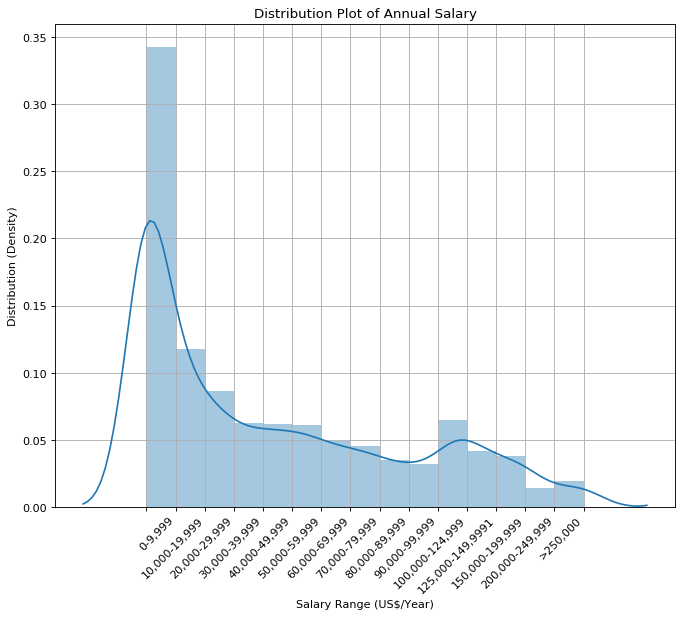

In [19]:
salary_buckets_reverse = {    
0:'0-9,999',
1:'10,000-19,999',
2:'20,000-29,999',
3:'30,000-39,999', 
4:'40,000-49,999', 
5:'50,000-59,999',
6:'60,000-69,999',
7:'70,000-79,999', 
8:'80,000-89,999', 
9:'90,000-99,999',
10:'100,000-124,999',
11:'125,000-149,9991',
12:'150,000-199,999',
13:'200,000-249,999',
14:'>250,000'
}

#separate targets and features
df_target = df_cleaned['Q10_Encoded']
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
fig = sns.distplot(df_target,hist=True,bins=15,norm_hist=True)
loc = np.arange(start=0, stop=14.8, step=14/15)
fig.set_xticks(range(0,15))
locs, labels = plt.xticks()
a=[""]*16
for i in range(1,16):
  a[i] = salary_buckets_reverse[i-1]
fig.set_xticklabels(a)
plt.xticks(rotation=45, ha="right" )
plt.xticks(loc)
plt.xlabel("Salary Range (US$/Year)")
plt.ylabel("Distribution (Density)")
plt.grid(True)
plt.title("Distribution Plot of Annual Salary") 
plt.show()


> As is shown in the distribution plot, the distribution is skewed heavily to the left with more than 20% samples having an annual salary of less than \$10000 per year. About 50% samples fail into the lowest three salary buckets (0-9999,10000-19999,20000-29999). The distribution plot implies that the majority of people earn less than \$30000 per year. **This plot can be a useful reference to check if the later predicted targets also fall into a similar distribution**



#### 2.1.2 Figure2: Histogram of Respondents' Age and Gender

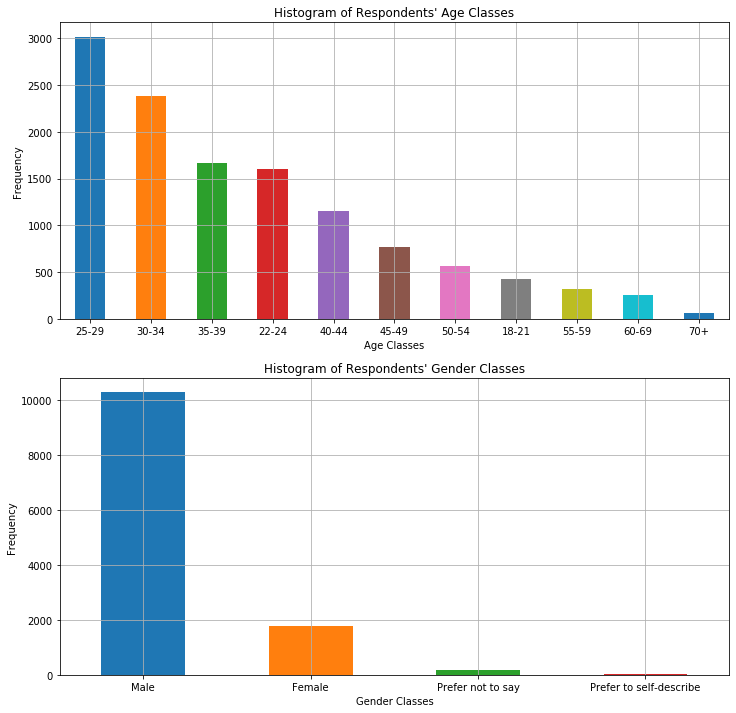

In [20]:
fig = plt.figure(figsize=(12,12))
#get gender and age data and count groups
gender_data = df_cleaned['Q2']
gender_count = gender_data.value_counts()
age_data = df_cleaned['Q1']
age_count = age_data.value_counts()

#prepare plots
plt.subplot(211)
fig = age_count.plot(kind = 'bar', rot = 0, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.grid(True)
plt.xlabel("Age Classes")
plt.ylabel("Frequency")
plt.title('Histogram of Respondents\' Age Classes')

plt.subplot(212)
gender_count.plot(kind = 'bar', rot = 0, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.grid(True)
plt.xlabel("Gender Classes")
plt.ylabel("Frequency")
plt.title('Histogram of Respondents\' Gender Classes')
plt.show()




> From the histogram we can tell that the majority of the respondents are aged between 25-34 and there is a significant gap between the number of male respondents and the number of female respondents (over 4 times male than female). **Looking at the structure of respondents can help us determine whether the dataset is biased due to unbalanced distribution.**





#### 2.1.3 Figure3: Box plot of Respondents' Salary Range vs. Years of Using Machine Learning Methods

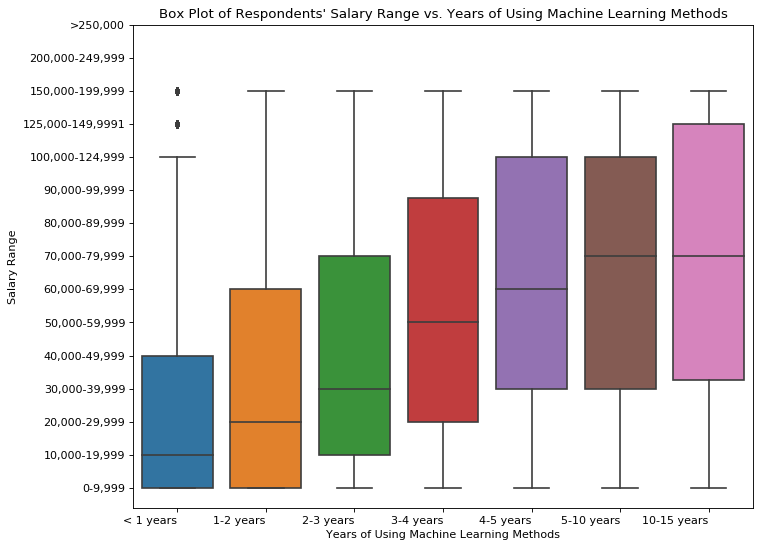

In [21]:
q23_encode_reverse = {1:'< 1 years',
              2:'1-2 years',
              3:'2-3 years',
              4:'3-4 years',
              5:'4-5 years',
              6:'5-10 years',
              7:'10-15 years',
              8:'20+ years'
             }

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
box_fig = sns.boxplot(data = df_encoded, x="Q23", y="Q10_Encoded")
plt.yticks(np.arange(15), ('0-9,999','10,000-19,999','20,000-29,999','30,000-39,999', '40,000-49,999', '50,000-59,999','60,000-69,999','70,000-79,999', '80,000-89,999', '90,000-99,999','100,000-124,999','125,000-149,9991','150,000-199,999','200,000-249,999','>250,000'))
a=[""]*8
for i in range(1,9):
  a[i-1] = q23_encode_reverse[i]
box_fig.set_xticklabels(a)
plt.xticks(rotation=0, ha="right")
plt.xlabel('Years of Using Machine Learning Methods')
plt.ylabel('Salary Range')
plt.title('Box Plot of Respondents\' Salary Range vs. Years of Using Machine Learning Methods')
plt.show()



> The box plot of "Respondents' Salary Range vs. Years of Using Machine Learning Methods' shows a very interesting trend **the more years the respondent is experienced in machine learning methods, the more average salary the respondent earns. This plot implies that "Years of using machine learning methods" might have a strong correlation to the salary.** In the future prediction, this correlation should be further analysed



### 2.2 Visualize the Order of Feature Importance
b. Visualize the order of feature importance. Some possible methods include correlation plot, or
a similar method. Given the data, which of the original attributes in the data are most related to
a survey respondent’s yearly compensation?
 The steps specified before are not in a set order. 

#### 2.2.1 Generate correlation matrix between features
In this section, we are trying to generate the correlation matrix and find the correlation between target (Q10) and other features and find out which features are mostly correlated with the target. This will provides us with some information about which features are more important than others when estimating the target (salary) 

In [0]:
#get the correlation 
corr_matrix = df_encoded.corr()
#Generate ehe correlation heatmap for
# corr_matrix.style.background_gradient(cmap=sns.diverging_palette(220, 20, as_cmap=True))



> **The above correlation matrix gives us a brief view of the correlation between each pair of features. But we are more interested in the relationship between the target ("Q10_Encoded") and the rest features, thus I'm extracting the correlation coefficient between "Q10_encoded" and the rest features and rank them from the largest to the smallest value**







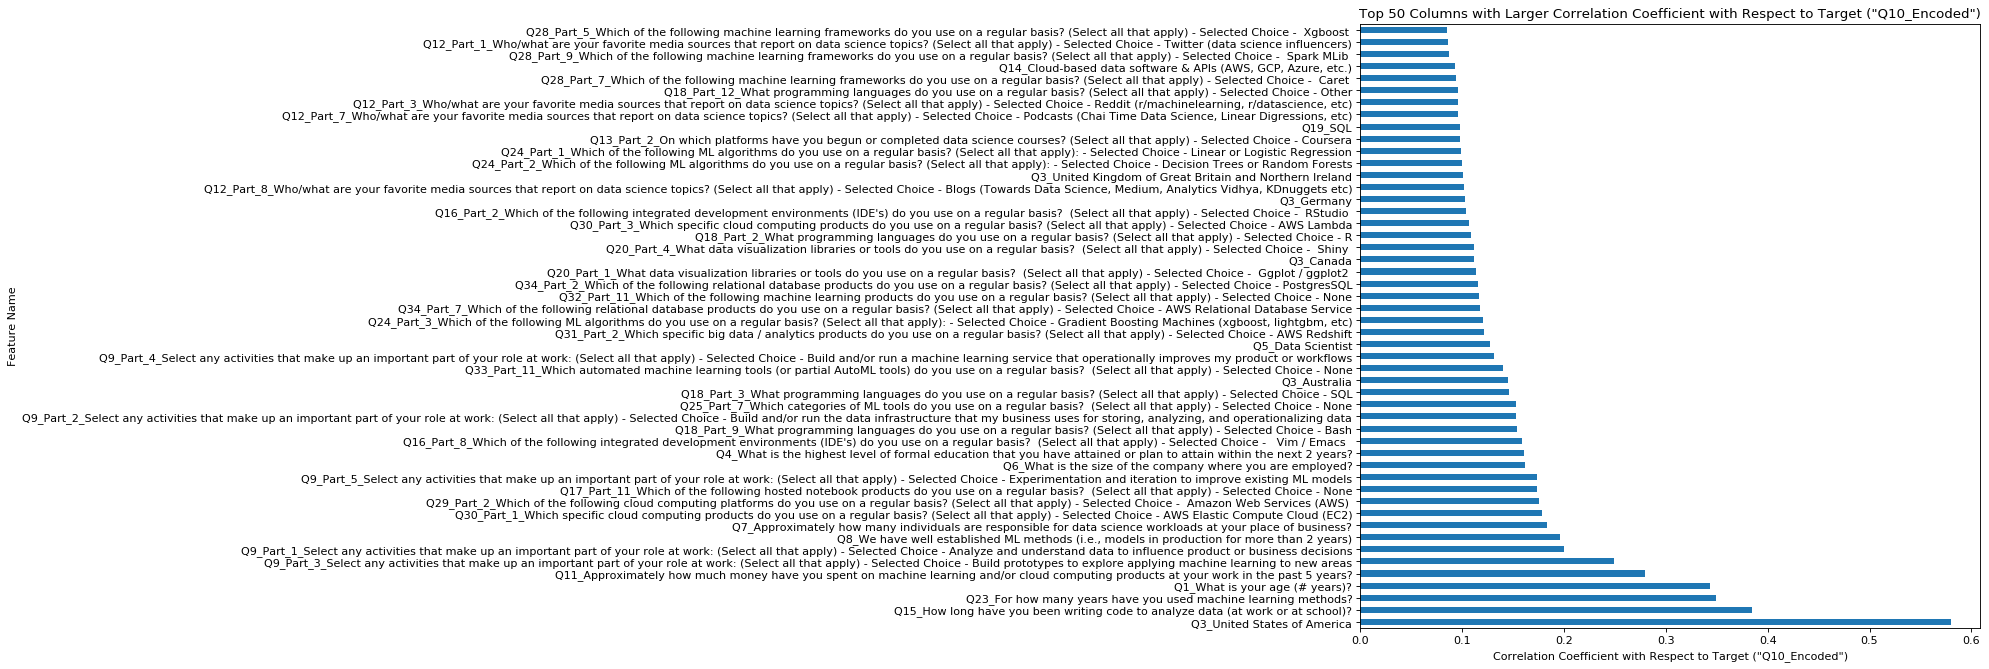

In [23]:
largest_cols = corr_matrix.nlargest(51, 'Q10_Encoded')['Q10_Encoded']
largest_cols = largest_cols[1:]
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
largest_cols.plot(kind="barh",)
plt.xlabel('Correlation Coefficient with Respect to Target ("Q10_Encoded")')
plt.ylabel('Feature Name')
plt.title('Top 50 Columns with Larger Correlation Coefficient with Respect to Target ("Q10_Encoded")')
locs, labels = plt.yticks()
label_str_ls = []
for lab in labels:
  label_str_ls.append(lab.get_text())
for i in range(len(label_str_ls)):
  col = label_str_ls[i]
  try:
    label_str_ls[i] = col + "_" + df_q_dict[col]
    # print(label_str_ls[i])
  except:
    pass
plt.yticks(np.arange(50), label_str_ls)
plt.show()



> As shown in the plot of "Top 50 Columns with Larger Correlation Coefficient with Respect to Target ("Q10_Encoded")", the column with highest Correlation Coefficient to target are:
1.   Q3: Whether the respondent is from USA or not
2.   Q15: "How long have you been writing code to analyze data"
3.   Q23: "For how many years have you used machine learning methods?"
4.   Q1: "What is your age (# years)?"
5.   Q11: "Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?"

> By analyzing the top correlated features, it can be concluded that the respondent's salary is most likely related to the respondent's age, years of experience in /amount of money spent on machine learning and coding experience. Despite that, the intersting finding is that the most correlated feature is whether the respondent is from USA, the reason might be that the average salary of respondents from USA is significantly larger than those from other countries.



> The correlation Coefficient provides us a straightforward way of measuring the strength of the relationship between two features







## 3.Feature selection (10 marks):
Explain how feature engineering is a useful tool in machine learning. Then select the features to
be used for analysis either manually or through some feature selection algorithm (e.g. regularized
regression).
Not all features need to be used; features can be removed or added as desired. If the resulting
number of features is very high, dimensionality reduction can also be used (e.g. PCA). Use at
least one feature selection technique – describe the technique and provide justification on why
you selected that set of features.



> **What is feature engineering:**
Feature engineering is the process of  extracting features from raw data via data mining techniques. The properly selected features can reduce the computational cost of the traning and classifying process and also improve the performance of the machien learning algorithms.





### 3.1 Remove redundant features with high feature correlation coefficient



> Notice that in the correlation matrix, there are some features which are strongly correlated, which means either of the feature can give almost the same information, this we can drop one of feature in each pair of features with high correlation coefficient, here I selected the drop threshold of correlation coefficient >= 0.6


In [24]:
print("Total number of features before drop:", len(df_encoded.columns)-1)
cols = np.full((corr_matrix.shape[0],), True, dtype=bool)
dropped_col = []
#loop through the correlation matrix and 
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.60:
            if cols[j]:
              dropped_col.append([corr_matrix.columns[i],corr_matrix.columns[j],corr_matrix.iloc[i,j]])
              cols[j] = False
selected_columns = df_encoded.columns[cols]
df_encoded = df_encoded[selected_columns]
print("Total number of features after drop:", len(df_encoded.columns)-1)

Total number of features before drop: 237
Total number of features after drop: 218


In [25]:
#print out the dropped features
for a,b,v in dropped_col:
    print("==========================")
    print("==>Question realted to dropped feature:")
    try:
      print(df_q_dict[a])
    except:
      print(a)
    print("==>Question realted to the paired feature:")
    try:
      print(df_q_dict[b])
    except:
      print:b
    print("Correlation Coefficient=",v)

==>Question realted to dropped feature:
Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice - Jupyter (JupyterLab, Jupyter Notebooks, etc) 
==>Question realted to the paired feature:
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python
Correlation Coefficient= 0.654278251196514
==>Question realted to dropped feature:
Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  RStudio 
==>Question realted to the paired feature:
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R
Correlation Coefficient= 0.8201158712754417
==>Question realted to dropped feature:
Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  RStudio 

By looking at the content of the dropped features, we can see that the feature pair with high correlation coefficient has a strong relationship, such as "Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  RStudio " vs. "What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R" these two features both provides information that the respondent have used R language



> The # of features dropped from 237 to 218 which is still very high, thus other feature selection methods needs to be further implemented



###3.2 Select Features using sklearn.feature_selection.SelectFromModel



> In this section, I use the API feature_selection.SelectFromModel from Sklearn to help further reduce the size of features. This API takes a trained model and removes less important features based on a threshold. Here, I pick LogisticRegression with default parameters as the model and set the threshold as "mean", I'm aiming at dropping down features down to less than 100 features 



In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

#Get the Test and train features
y=df_encoded["Q10_Encoded"]
X=df_encoded.drop(['Q10_Encoded'], axis=1)

print("Total number of features before:", len(X.columns))

#Build the default logictic regression model
lr = LogisticRegression()   ##LASSO？
lr.fit(X, y);

#get the selected features
model = SelectFromModel(lr, prefit=True, threshold='1.25*mean')
X_Selected = X.copy()[X.columns[(model.get_support())]]

print("Total number of features After drop:", X_Selected.shape[1])

Total number of features before: 218
Total number of features After drop: 35


### 3.3 Impliment PCA to reduce the dimension

In [0]:
from sklearn.decomposition import PCA
shape_before = X_Selected.shape
print("Dataframe Shape Before PCA:", shape_before)
pca = PCA(0.9999) # for plot only, just want the trend line
pca.fit(X_Selected) # for plot only
trend = np.cumsum(pca.explained_variance_ratio_) 
pca = PCA(0.95) #preserving 95% features, the actual PCA
pca.fit(X_Selected)
X_Selected_PCA_transformed = pca.transform(X_Selected)
shape_after = X_Selected_PCA_transformed.shape
print("Dataframe Shape After PCA:", shape_after)



> Principal component analysis (PCA) is a commonly used method for reducing features while still keeping most of the information. Here I used PCA to reduce the dimension of the selected features while preserving 95% variance





> As shown from the plot, after PCA, the dimension is reduced from 35 to 27 while the dataset still keeps explained variance 0.95



## 4.Model implementation (25 marks):
Implement logistic regression algorithm on the training data using 10-fold cross-validation. How
does your model accuracy compare across the folds? What is average and variance of accuracy for
folds? Treating each value of hyperparameter(s) as a new model, which model performed best?
Give the reason based on bias-variance trade-off. An output of your algorithm should be a
probability of belonging to each of the salary buckets. Apply scaling/normalization of features, if
necessary.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel


X_train, X_test, y_train, y_test = train_test_split(X_Selected_PCA_transformed, y, test_size=0.3, random_state=0)
lr = LogisticRegression()    
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
y_pred = lr.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
# acc = lr.score(X_test, y_test)
# acc


0.37214509628302733

## 5.Model tuning (20 marks):
Improve the performance of the models from the previous step with hyperparameter tuning and
select a final optimal model using grid search based on a metric (or metrics) that you choose.
Choosing an optimal model for a given task (comparing multiple classifiers on a specific domain)
requires selecting performance measures, for example accuracy, precision, recall and/or F1-score
to compare the model performance.
There is no minimum model accuracy, as long as your methodology is reasonable and well
explained. 

## 6.Testing & Discussion (10 marks):
Use your optimal model to make classifications on the test set. How does your model perform on
the test set vs. the training set? The overall fit of the model, how to increase the accuracy (test,
training)? Is it overfitting or underfitting? Why? Plot the distribution.
Insufficient discussion will lead to the deduction on marks. 